In [1]:
#| default_exp group

# Group

> Module for creating groups of the transcript, specifically for paragraphs, speakers, and topics.

# Information

This module will provide the functionality of splitting our fully transcribed text into desired groups. The grouping hierarchy in order from smallest to largest:

1. Sentences
2. Paragraphs
3. Speaker's Speech
4. Topics

We'll want to preserve consistency here, so the format of the functions should remain similar, and the inputs / outputs should the same. 

It would be good to preserve the timestamp information on the word-level as the output, so we keep these in all the groupings. The grouping methods will then deal with arrays of sentences, containing arrays of word objects. Since the topic, and paragraph splitting is done on sentence embeddings, we make all functions take in sentences as the input. The outputs will then be these sentences grouped together.

# Groups

## Sentences

In order to group sentences, we first need to get a list of sentences. This is easily done, we simply split the words whenever there is a full stop (or '!'/'?'). 

There's one more condition though and that's the minimum length of the sentence. This is quite important, as we are making groups based on the similarity of embeddings. Small sentences containing short utterances could skew the split points disproportionately. So here we could either join sentences together, or remove them from the consideration. 

If we remove them from the consideration, we'd need some way of determining which group they go into ie. whether there's a cutoff before or after them. This might be a bit too complicated, as well as this it is possible that they contain information relavent to the consideration. So here we'll just join short sentences together.

## Paragraphs

### Aims

Straightforward requirements here, and that is to introduce a method that can quickly split lengthy text into separate paragraphs. 

The only use case here is for increased readability, so accuracy isn't at utmost importance.

### Approach

Found [a method online](https://github.com/poloniki/quint/blob/master/notebooks/Chunking%20text%20into%20paragraphs.ipynb) which takes embeddings of sentences, and finds split points at points of a significant change between them.

## Speakers

From the diarized transcript, we simply want to be able to group segemnets where the speaker doesn't change, to display as one in the final output.

## Topics

### Aims

Always useful to consider, and reconsider your aims when researching. 

We are looking for a way of grouping up chapters or topics of the text. 

The purpose or exact use cases should be considered. Currently I am looking for a tool that can be used for revision of a podcast, though I can of course see it being used further as the sole way of getting a podcast's content. So if possible, choosing methods that would allow both would ideal, but the focus should be kept to the former.

So the objective of the former rereading method asks for a lot less. It simply requires the core ideas to be displayed in any format, to only allow the reader to remind themselves what at point of the conversation this was mentioned. This can be done simply by displaying the keywords found by the topics.

From the no-listen perspective, more is required from the topics. The splits could be the same, but the labels would need to be more descriptive. Although, this might be the wrong way of thinking about it. What would be required from a reading perspective is real summaries, accurate, and concise in their requirements.

### Approach

What we require here is a way of first grouping the text into topics, and then finding a way to summarise them through a title (and possibly a paragraph summary).

### Clustering

There are various different ways of splitting the topics, which all come under the category 'Topic Modelling.' They tend to be statistical methods concerned with creating embeddings of the text, reducing their dimensionality, and then clustering them. 

### Summarisation

For the latter, LLM's seem like the perfect use case for this as a summarisation task. They are excellent at summarising as they do have some way of understanding language, and are also able to output that understanding into words. The only issue with this approach is the cost, as they are much more computationally costly as a direct method designed for the task.

# Implementation

## Setup

In [2]:
#| export
import pandas as pd
import numpy as np
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import argrelextrema
import math
from nltk.stem import WordNetLemmatizer
from nltk import download
from functools import partial, update_wrapper

In [3]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#| export 
download("wordnet")

[nltk_data] Downloading package wordnet to /Users/steph/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
with open("../data/podcast/lex_ai_stephen_wolfram_1/tmp/transcript.json") as f:
    transcript = json.load(f)

## Sentences

In [6]:
#| export
def group_sentences(words, min_length=10):
    group_idxs = [0]
    for i, w in enumerate(words):
        w = w['word'].replace('?', '.')
        if (w.endswith('.') or w.endswith('. ')) and (i - (group_idxs[-1] + 1)) >= min_length: 
            group_idxs.append(i+1)
    if len(group_idxs) > 1:
        group_idxs.pop()
    sentences = [ words[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return sentences, group_idxs

In [7]:
#| export
# wrapper around original function to be used for pure text
def group_sentences_text(text):
    words = [{"word": w} for w in text.split(" ")]
    sentences, _ = group_sentences(words)
    return sentences

In [8]:
transcript_text = ' '.join([word['word'] for word in transcript['words']])
sentences = group_sentences_text(transcript_text)[0]

In [9]:
sentences_indexed = group_sentences(transcript['words'])
sentences, sentence_idxs  = sentences_indexed
sentences[1][:3], sentence_idxs[1]

([{'word': "He's",
   'start': 16.34,
   'end': 16.48,
   'score': 0.354,
   'speaker': 'SPEAKER_01'},
  {'word': 'the',
   'start': 16.5,
   'end': 16.6,
   'score': 0.812,
   'speaker': 'SPEAKER_01'},
  {'word': 'author',
   'start': 16.68,
   'end': 17.021,
   'score': 0.804,
   'speaker': 'SPEAKER_01'}],
 38)

## Paragraphs

A simple task of finding points where long periods of text can be divided into paragraphs.

In [10]:
embedding_model = SentenceTransformer('all-mpnet-base-v2')
embeddings = embedding_model.encode(sentences)
embeddings.shape

(1249, 768)

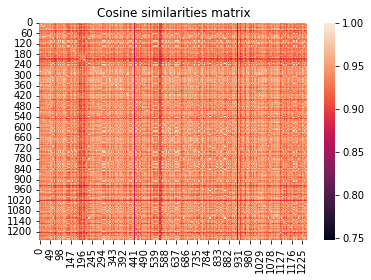

In [11]:
similarity_matrix =  cosine_similarity(embeddings)
sns.heatmap(similarity_matrix).set_title('Cosine similarities matrix');

In [12]:
#| export
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))
    
def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum 
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid) 
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

In [13]:
# Let's apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarity_matrix, p_size=10)

# Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.

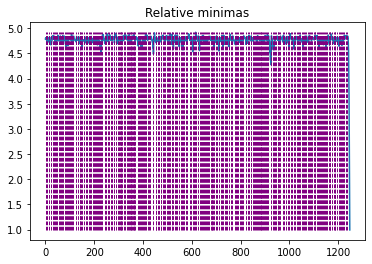

In [14]:
# Let's create empty fig for our plor
fig, ax = plt.subplots()
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

In [15]:
#| export
def split_on_minimas(sentences, minimas):
    group_idxs = [ m for m in minimas[0] ]
    group_idxs.insert(0,0)
    paragraphs = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return paragraphs, group_idxs

In [16]:
#| export
def get_abs_indexes(sentence_idxs, relative_indexes):
    return [ sentence_idxs[i] for i in relative_indexes ]

In [17]:
#| export
def group_paragraphs(sentences):
    if len(sentences) < 8: 
        return [sentences], [0]
    sentences_text = [ ' '.join([ word['word'] for word in s ]) for s in sentences ]
    embedding_model = SentenceTransformer('all-mpnet-base-v2')
    embeddings = embedding_model.encode(sentences_text)
    similarities = cosine_similarity(embeddings)
    activated_similarities = activate_similarities(similarities, p_size=8)
    minimas = argrelextrema(activated_similarities, np.less, order=2)
    paragraphs, group_idxs = split_on_minimas(sentences, minimas)
    return paragraphs, group_idxs

In [18]:
#| export
# wrapped around original function to be used with pure text as opposed to sentence grouped words
def group_paragraphs_text(text):
    words = [{"word": w} for w in text.split(" ")]
    sentences, _ = group_sentences(words)
    paragraphs, _ = group_paragraphs(sentences)
    paragraphs = '\n\n'.join([ ' '.join([  ' '.join([ word['word'] for word in sentence ]) for sentence in paragraph ]) for paragraph in paragraphs ])
    return paragraphs

In [19]:
paragraphs = group_paragraphs_text(transcript_text)
paragraphs

"The following is a conversation with Stephen Wolfram, a computer scientist, mathematician, and theoretical physicist, who is the founder and CEO of Wolfram Research, a company behind Mathematica, Wolfram Alpha, Wolfram Language, and the new Wolfram Physics Project. He's the author of several books, including A New Kind of Science, which, on a personal note, was one of the most influential books in my journey in computer science and artificial intelligence.\n\nIt made me fall in love with the mathematical beauty and power of cellular automata. It is true that perhaps one of the criticisms of Stephen is on a human level, that he has a big ego, which prevents some researchers from fully enjoying the content of his ideas. We talk about this point in this conversation. To me, ego can lead you astray, but can also be a superpower, one that fuels bold, innovative thinking that refuses to surrender to the cautious ways of academic institutions. And here, especially, I ask you to join me in lo

In [20]:
paragraphs, paragraph_idxs = group_paragraphs(sentences[:40])
paragraphs[0][0][:3]

[{'word': 'The',
  'start': 0.128,
  'end': 0.208,
  'score': 0.947,
  'speaker': 'SPEAKER_01'},
 {'word': 'following',
  'start': 0.248,
  'end': 0.568,
  'score': 0.846,
  'speaker': 'SPEAKER_01'},
 {'word': 'is',
  'start': 0.608,
  'end': 0.668,
  'score': 0.785,
  'speaker': 'SPEAKER_01'}]

In [21]:
print([ len(paragraph) for paragraph in paragraphs ])

[2, 5, 5, 6, 8, 6, 8]


## Topics

### Topic Modelling Methods

#### Cosine Similarity Minima

Trying out applying the minima at paragraph-level to obtain topics.

-> Deleted as methods changed. Revamp when investigating

### Clustering

Trying out simple clustering on embedded vectors of sentences/paragraphs.

This is at minimum a 2-step process. First we need to embed our sentences, and then cluster them into topics.

#### Embeddings

In [22]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [23]:
sentence_embeddings = sentence_model.encode(sentences)
sentence_embeddings.shape

(1249, 768)

In [24]:
#| export
def get_position_embeddings(seq_len, d, n=1000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

In [25]:
position_embeddings = get_position_embeddings(*sentence_embeddings.shape)
position_embeddings.shape

(1249, 768)

In [26]:
print(np.min(sentence_embeddings), np.max(sentence_embeddings))
print(np.min(position_embeddings), np.max(position_embeddings))

-0.14712584 0.15733677
-0.9999999999718351 1.0


In [27]:
position_embeddings = position_embeddings * (np.max(sentence_embeddings) / np.max(position_embeddings))
print(np.min(position_embeddings), np.max(position_embeddings))

-0.15733677148375833 0.1573367714881897


In [28]:
#| export
def get_embeddings(sentences):
    sentence_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    sentence_embeddings = sentence_model.encode(sentences)
    position_embeddings = get_position_embeddings(*sentence_embeddings.shape)
    position_embeddings = position_embeddings * (np.max(sentence_embeddings) / np.max(position_embeddings)) # scale to match sentence embeddings
    return sentence_embeddings + position_embeddings

#### Clustering

Decision: Cluster sentences or paragraphs?

I think this depends whether the paragraph splitting is good or not. Are the paragraph splitting more or less likely to find the best topic splits.

In [29]:
#| export
from sklearn.cluster import KMeans

In [30]:
num_clusters = 15
num_clusters

15

In [31]:
final_embeddings = sentence_embeddings+position_embeddings

In [32]:
clusters = KMeans(n_clusters=num_clusters).fit(final_embeddings)

/opt/homebrew/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [33]:
sentences_clustered = list(zip(clusters.labels_, sentences))

In [34]:
#| export
# splitting topics into consecutive topics 
def get_topic_splits(sentences_clustered):
    group_idxs = [0]
    for i in range(1, len(sentences_clustered)):
        if sentences_clustered[i][0] != sentences_clustered[i-1][0]: 
            group_idxs.append(i)
    return group_idxs

In [35]:
group_idxs = get_topic_splits(sentences_clustered)
topic_idxs = get_abs_indexes(sentence_idxs, group_idxs)

In [36]:
#| export
def group_topics(sentences, n_topics):
    sentences_text = [ ' '.join([ word['word'] for word in s ]) for s in sentences ]
    embeddings = get_embeddings(sentences_text)
    clusters = KMeans(n_clusters=n_topics).fit(embeddings)
    sentences_clustered = list(zip(clusters.labels_, sentences))
    group_idxs = get_topic_splits(sentences_clustered)
    topics = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return topics, group_idxs

In [37]:
topics, topic_idxs = group_topics(sentences, num_clusters)
len(topics)

/opt/homebrew/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


15

### Visualisation

In [38]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(final_embeddings - clusters.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

closest_indices.sort()
closest_indices

[54, 160, 247, 337, 411, 504, 589, 670, 749, 827, 905, 980, 1054, 1131, 1207]

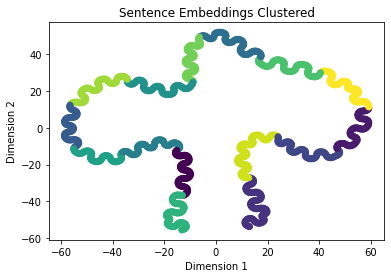

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(final_embeddings)

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=clusters.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sentence Embeddings Clustered')
plt.show()

### Reference Labels

To compare the results we can use the topics supplied in the [podcast's RSS feed](https://lexfridman.com/feed/podcast/) as a reference.

In [40]:
with open("../data/podcast/lex_ai_stephen_wolfram_1/topics.txt") as f:
    ref_labels_text = f.read()

In [41]:
from datetime import datetime

In [42]:
def timestamp_to_seconds(timestamp):
    if len(timestamp.split(":")) == 3:
        timestamp = datetime.strptime(timestamp, "%H:%M:%S")
    else:
        timestamp = datetime.strptime(timestamp, "%M:%S")
    datetime_base = datetime.strptime("00:00:00", "%H:%M:%S")
    return (timestamp-datetime_base).seconds

In [43]:
def get_timestamp_word_index(timestamp):
    for i, w in enumerate(transcript['words']):
        if int(w['start']) >= timestamp:
            return i

In [44]:
def get_topic_obj(topic_line):
    split = topic_line.split(' - ')
    heading = split[1]
    timestamp = split[0]
    timestamp_s = timestamp_to_seconds(timestamp)
    index = get_timestamp_word_index(timestamp_s)
    return {'heading': heading, 'timestamp': timestamp, 'index': index}

In [45]:
ref_labels = list(map(get_topic_obj, ref_labels_text.splitlines()))

In [46]:
pd.DataFrame(ref_labels)

,heading,timestamp,index
0,Introduction,00:00,0
1,Communicating with an alien intelligence,04:16,690
2,Monolith in 2001: A Space Odyssey,12:11,1981
3,What is computation?,29:06,4828
4,Physics emerging from computation,44:54,7434
5,Simulation,1:14:10,12544
6,Fundamental theory of physics,1:19:23,13432
7,Richard Feynman,1:28:01,14974
8,Role of ego in science,1:39:57,17095
9,Cellular automata,1:47:21,18385


In [47]:
topic_word_idxs = get_abs_indexes(sentence_idxs, topic_idxs)

In [48]:
print(len(topic_word_idxs), len(ref_labels))
print(topic_word_idxs)
print([l['index'] for l in ref_labels])

15 15
[0, 1870, 3615, 5750, 8351, 10846, 13241, 15637, 18305, 20698, 22480, 24416, 26594, 28345, 30559]
[0, 690, 1981, 4828, 7434, 12544, 13432, 14974, 17095, 18385, 23210, 30170, 30582, 31342, 31845]


This looks reasonable, it seems to find  cutoffs near to eachother. Though are they simply just evenly spaced out?

In [49]:
spacings = [topic_word_idxs[i+1] - topic_word_idxs[i] for i in range(len(topic_word_idxs)-1)]
np.mean(spacings), np.std(spacings)

(2182.785714285714, 309.75132389234625)

That's quite a high standard devation, much higher than zero anyway. 

In [50]:
baseline = np.linspace(0,topic_word_idxs[-1],15).astype(int)
print(baseline)
print(topic_word_idxs)

[    0  2182  4365  6548  8731 10913 13096 15279 17462 19645 21827 24010
 26193 28376 30559]
[0, 1870, 3615, 5750, 8351, 10846, 13241, 15637, 18305, 20698, 22480, 24416, 26594, 28345, 30559]


With this form of clustering, there definitely is a bias towards getting evenly sized clusters, but that's also okay. It might even be what we want, as the reader can easily distinguish between similar sounding titles and topics.

## Speakers

Simply just grouping consecutive speakers together. In order to keep things consistent we want to take sentences as the input, which we flatten to words immediately.

In [51]:
#| export
# flattening sentence array
def sentences_to_words(sentences):
    return [word for sentence in sentences for word in sentence]

In [135]:
#| export
# creating speech groups by consecutive speaker
def group_speakers(sentences):
    # reformat sentences without minimum length to allow proper character splitting
    sentences, _ = group_sentences(sentences_to_words(sentences),0)
    group_idxs = [0]
    for i in range(1, len(sentences)):
        if sentences[i][0]['speaker'] != sentences[i-1][0]['speaker']:
            group_idxs.append(i)
    speaker_groups = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return speaker_groups, group_idxs

In [94]:
speaker_groups, group_idxs = group_speakers(sentences)

## Full Grouping

We do this in a hierarchical manner, from the top down in terms of the group's scale.

In [53]:
#| export
def get_group_type(group_function):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(group_function.__name__.split("_")[1])

In [54]:
#| export
def label_groups(groups, group_type):
    word_label = True if group_type in groups[0][0][0] else False
    return [ {
            'type': group_type,
            'label': group[0][0][group_type] if word_label else i,
            'start': group[0][0]['start'],
            'end': group[-1][-1]['end'],
            'text': ' '.join([word['word'] for word in sentences_to_words(group)]),
            'groups': group
        } for i, group in enumerate(groups)
    ]

In [55]:
#| export
# warpper function to allow `function.__name__` attribute to be called for partial functions
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [56]:
#| export
def group_and_label(sentences, split_functions):
    split_function = split_functions[0]
    groups, _ = split_function(sentences)
    groups = label_groups(groups, get_group_type(split_function))
    split_functions = split_functions[1:]
    if split_functions: # nest function if there are more groupings
        for i, group in enumerate(groups):
            groups[i]['groups'] = group_and_label(group['groups'], split_functions)
    else: # cleanup at the end
        for i, group in enumerate(groups):
            groups[i]['words'] = [word for sentence in groups[i]['groups'] for word in sentence]
            groups[i].pop('groups')
    return groups

In [57]:
n_topics=len(ref_labels)
split_functions = [wrapped_partial(group_topics, n_topics=n_topics), group_speakers, group_paragraphs]
all_groups = group_and_label(sentences, split_functions)

In [58]:
with open("../data/podcast/lex_ai_stephen_wolfram_1/tmp/transcript-grouped.json", 'w') as f:
    json.dump(all_groups, f, ensure_ascii=False, indent=2)

## Parameters

### n_topics

We need to choose the number of topics, which can be arbitrary. To allow for one-shot summarisation we'd like to keep the topics under 3796 tokens, which is ~2700 words. 

In [59]:
3796/1.4

2711.4285714285716

We should also give leeway accounting for differences in sized. Can the amount be determined by the topic size statistics?

In [60]:
topic_wcs = [len(topic['text'].split(' ')) for topic in all_groups]
np.std(topic_wcs), np.mean(topic_wcs), np.std(topic_wcs)/np.mean(topic_wcs)

(306.5545882148162, 2183.133333333333, 0.14041954448414337)

In [61]:
2700*(1-(0.13*1.5))

2173.5

In [62]:
#| export
def get_n_topics(words): return int(np.ceil(len(words)/2150))

In [63]:
get_n_topics(transcript['words'])

16

In [64]:
#| export
def group(words, n_topics=None, split_functions=None):
    if not n_topics: n_topics = get_n_topics(words)
    sentences, _ = group_sentences(words) # functions standardised to take sentences as inputs, as this is what is required for topics & paragraphs
    split_functions = [wrapped_partial(group_topics, n_topics=n_topics), group_speakers, group_paragraphs] if not split_functions else split_functions
    transcript_split = group_and_label(sentences, split_functions)
    return transcript_split

In [65]:
transcript_split = group(transcript['words'])
len(transcript_split)

16

In [66]:
[len(topic['text'].split(' ')) for topic in transcript_split]

[1931,
 1684,
 2039,
 2578,
 1971,
 1426,
 1942,
 2193,
 2113,
 1696,
 1921,
 2102,
 2107,
 2574,
 2364,
 2106]

In [67]:
with open("../data/podcast/lex_ai_stephen_wolfram_1/tmp/transcript-grouped.json", 'w') as f:
    json.dump(transcript_split, f, ensure_ascii=False, indent=2)

In [136]:
#| hide
from nbdev import nbdev_export
nbdev_export()

# Appendix

# Investigating

## Cleaning

Decision: To clean the text or not?
- embeddings are used to extract meaning from sentences - so technically it shouldn't make a difference
- is there anything I'm losing from cleaning the text?
    - possibly as the cleaning might end up alterning/removing key words

Lets compare outcomes.

In [69]:
from transcriber.sections.clean import clean

ModuleNotFoundError: No module named 'transcriber'

In [ ]:
#| export
# creating speech groups by consecutive speaker
def group_speakers(sentences):
    words = sentences_to_words(sentences)
    group_idxs = [0]
    for i in range(1, len(words)):
        if words[i]['speaker'] != words[i-1]['speaker']:
            group_idxs.append(i)
    word_groups = [ words[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    sentence_groups = [ group_sentences(words)[0] for words in word_groups ]
    return sentence_groups, group_idxs

In [ ]:
sentences_cleaned = []
for sentence in sentences:
    sentence_text = ' '.join([word['word'] for word in sentence])
    sentence_text_cleaned = clean(sentence_text)
    words = [{'word': word} for word in sentence_text_cleaned.split(' ')]
    sentences_cleaned.append(words)

len(sentences), len(sentences_cleaned)

(1249, 1249)

In [ ]:
topics_cleaned, topic_idxs_cleaned = group_topics(sentences_cleaned, n_topics)

In [ ]:
print(topic_idxs)
print(topic_idxs_cleaned)

[0, 105, 190, 259, 321, 393, 473, 551, 637, 721, 795, 867, 949, 1040, 1145]
[0, 73, 145, 231, 327, 414, 483, 550, 631, 725, 826, 919, 1001, 1089, 1173]


There isn't too much difference here, but interestingly there is some. This will become more clear when looking at the output of the topics.

In [ ]:
def sentences_to_text(sentences): return ' '.join([' '.join([word['word'] for word in sentence]) for sentence in sentences])

In [ ]:
topic_split_boundaries = [ {'previous': sentences_to_text(sentences[i-2:i]), 'beginning': sentences_to_text(sentences[i:i+2])} for i in topic_idxs ]
topic_cleaned_split_boundaries = [ {'previous': sentences_to_text(sentences[i-2:i]), 'beginning': sentences_to_text(sentences[i:i+2])} for i in topic_idxs_cleaned ]
list(zip(topic_split_boundaries, topic_cleaned_split_boundaries))[:4]

[({'previous': '',
   'beginning': "The following is a conversation with Stephen Wolfram, a computer scientist, mathematician, and theoretical physicist, who is the founder and CEO of Wolfram Research, a company behind Mathematica, Wolfram Alpha, Wolfram Language, and the new Wolfram Physics Project. He's the author of several books, including A New Kind of Science, which, on a personal note, was one of the most influential books in my journey in computer science and artificial intelligence."},
  {'previous': '',
   'beginning': "The following is a conversation with Stephen Wolfram, a computer scientist, mathematician, and theoretical physicist, who is the founder and CEO of Wolfram Research, a company behind Mathematica, Wolfram Alpha, Wolfram Language, and the new Wolfram Physics Project. He's the author of several books, including A New Kind of Science, which, on a personal note, was one of the most influential books in my journey in computer science and artificial intelligence."}),

This would become more clear if we knew what the topics were about. #todo after summarisation is complete.

## Programmatic Assistance

There are a few innacuracies of the transcript which could be helped programmatically. 

The first one being the grouping of the speakers. The cut off between speakers often happens too early, occurring in the middle of a sentence. The speakers are assigned at each whisper 'utterance' that is recorded. We could bound this to be done at each sentence instead.

Yes this bound will limit the accuracy of specific cases where speakers interrupt eachother mid-sentence. But that doesn't happen often, and regardless for readability it still helps to have the sentence in tact.

Here we can see that utterances aren't specifically sentences.

In [121]:
for segment in transcript['segments'][0][:100]:
    if not (segment['text'].endswith('.') or segment['text'].endswith('?')):
        print(segment['text'])

Well,
 So I think by the time, given the setup of your question,
So if we look at aliens visiting, and we'll get to discuss computation and the world of computation,
In a world of the future, if that's represented in computational language, we might be able to take the concept visit
How do we say the physical processes going on that represent sophisticated computations in the weather
And my guess is people will sort of get comfortable with the fact that both of these have been achieved


We can see that many of the speaker groups assigned aren't sentences.

In [127]:
interrupted_sentences = []
for g in speaker_groups[:100]:
    endword = g[-1][-1]['word']
    if not (endword.endswith('.') or endword.endswith('?')):
        interrupted_sentences.append(endword)

print(interrupted_sentences)
len(interrupted_sentences)

["we're", 'own', 'equate', 'talk', 'What', 'know,', 'Her', "that's", 'mean-', 'interested', 'So', 'to', 'figure', "That's", 'some,', 'know', 'create', 'I', 'you', 'I', 'of', 'way,', 'So', 'of', 'What', 'feel', 'It', 'that', 'Just', 'comprehend', 'So', 'create', 'So', 'I', 'behind', 'of', 'your', 'kind', 'randomness', 'Yes,', 'So']


41

In [129]:
def group_speakers2(sentences):
    # reformat sentences without minimum length to allow proper character splitting
    sentences, _ = group_sentences(sentences_to_words(sentences),0)
    group_idxs = [0]
    for i in range(1, len(sentences)):
        if sentences[i][0]['speaker'] != sentences[i-1][0]['speaker']:
            group_idxs.append(i)
    speaker_groups = [ sentences[i:j] for i, j in zip(group_idxs, group_idxs[1:]+[None]) ]
    return speaker_groups, group_idxs

In [130]:
speaker_groups2, _ = group_speakers2(sentences)

In [131]:
interrupted_sentences = []
for g in speaker_groups2[:100]:
    endword = g[-1][-1]['word']
    if not (endword.endswith('.') or endword.endswith('?')):
        interrupted_sentences.append(endword)

print(interrupted_sentences)
len(interrupted_sentences)

[]


0

## Other Methods

### BERTopic

In [ ]:
from hdbscan import HDBSCAN
from sklearn.datasets import fetch_20newsgroups
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.dimensionality import BaseDimensionalityReduction

c:\Users\steph\.conda\envs\whisperx\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\steph\.conda\envs\whisperx\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\steph\.conda\envs\whisperx\lib\site-packages\umap\distances.py:1086: NumbaDepreca

In [ ]:
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
np.max(final_embeddings)

0.3912078657624791

In [ ]:
empty_dimensionality_model = BaseDimensionalityReduction()
representation_model = KeyBERTInspired()
cluster_model = HDBSCAN(min_cluster_size = 15, 
                        metric = 'euclidean', 
                        cluster_selection_method = 'eom', 
                        prediction_data = True)
cluster_model = KMeans(n_clusters=num_clusters)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
topic_model = BERTopic(umap_model=empty_dimensionality_model)
# topic_model = BERTopic(umap_model=empty_dimensionality_model,
#                        ctfidf_model=ctfidf_model,
#                        hdbscan_model=cluster_model)
topics, probs = topic_model.fit_transform(sentences, final_embeddings)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,228,-1_the_and_of_you,"[the, and, of, you, that, it, to, its, is, know]","[I mean, it's like when you ask about, I don't..."
1,0,1379,0_of_the_you_and,"[of, the, you, and, that, to, is, know, it, in]",[And that's the same type of thing that we're ...
2,1,151,1_of_the_that_is,"[of, the, that, is, and, to, we, in, kind, you]",[And I think that's sort of the thing which is...


In [ ]:
topic_model.get_document_info(sentences)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,The following is a conversation with Stephen W...,5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
1,"He's a computer scientist, mathematician, theo...",5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
2,He has been a pioneer in exploring the computa...,5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
3,"And now, a quick few second mention of each sp...",5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
4,It's the best way to support this podcast. We ...,5,5_on_do_out_slash,"[on, do, out, slash, lex, programs, take, can,...","[And so the question is, when you look at sort...",on - do - out - slash - lex - programs - take ...,False
...,...,...,...,...,...,...,...
1753,"This is round number four. We'll, I'm sure, ta...",4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False
1754,Thank you so much. My pleasure. Thanks for lis...,4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False
1755,"To support this podcast, please check out our ...",4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False
1756,"And now, let me leave you with some words from...",4,4_ruliad_universe_we_aggregate,"[ruliad, universe, we, aggregate, existence, a...","[And here's the thing that I, sort of the exci...",ruliad - universe - we - aggregate - existence...,False


In [ ]:
list(zip(topics, probs))[:5]

[(29, 0.9545541349302722),
 (29, 1.0),
 (-1, 0.0),
 (18, 0.7329591875073076),
 (18, 1.0)]

In [ ]:
from scipy.cluster import hierarchy as sch

linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(sentences, linkage_function=linkage_function)

100%|██████████| 44/44 [00:01<00:00, 29.16it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
topic_model.visualize_topics()

### Text Tiling

This requires paragraphs to be already split for some reason.

In [ ]:
from nltk.tokenize import TextTilingTokenizer
ttt = TextTilingTokenizer(w=500) # play around with this parameter

In [ ]:
transcript['text'][:250]

"Welcome to the Making Sense Podcast.\n\nThis is Sam Harris. Today I'm speaking with Shamil Chandaria. Shamil is a philanthropist, an entrepreneur, a technologist, and an academic with multidisciplinary research interests spanning computational neurosci"

In [ ]:
sections = ttt.tokenize(transcript['text'])

In [ ]:
# showing number of topics, as well as the number of words in each
print(len(sections), [ len(section.split(' ')) for section in sections ])

6 [1456, 5056, 1911, 4533, 1996, 1349]
